In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)

In [2]:
beam, lattice = impact.readInputFile('test.SF.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
Nturn = np.array([128,256,512,1024])
ChaosPercent = 99.0
iTBTF = {}
iTBTB = {}
TBTF = {}
TBTB = {}
X = {}
Y = {}
XB = {}
YB = {}
Npt = {}

betx = lattice[2].betx
alfx = 0.0
NL_c = lattice[2].transverse_scale_c
x0 = betx**0.5*NL_c
x0 = [-x0,x0]
y0 = [0,0]

reading ImpactZ input file (test.SF.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [3]:
pData = impact.readParticleData('partcl.data.chad',ke,mass,freq)
counts,xbins,ybins=np.histogram2d(pData[:,0],pData[:,2],bins=16)
print(np.min(pData[:,0]))

-0.010150092256514708


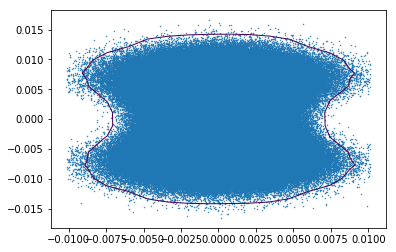

In [4]:
plt.contour(counts.transpose(),
            extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
            linewidths=1,linestyles='solid',levels=[250])
plt.scatter(pData[:,0],pData[:,2],s=0.2)

In [5]:
for nturn in Nturn:
    iTBTF[nturn],TBTF[nturn] = impact.readTBT(nturn,ke,mass,freq)
    iTBTB[nturn],TBTB[nturn] = impact.readTBT(nturn+100000,ke,mass,freq)
    Npt[nturn] = len(iTBTB[nturn])

In [6]:
def findSameIndex(table1,index1,table2,index2):
    for i in range(len(table2)-index2+1):
        #print(index1,index2,table1[index1],table2[index2],table1[index1]==table2[index2])
        if table1[index1] == table2[index2]:
            return index2
        else:
            index2 = index2+1
    print('max_reached,index1,index2=',index1,index2,len(table1),len(table2),table1[index1],table2[index2])

In [7]:
for n in range(len(Nturn)):
    nturn = Nturn[n]
    npt = len(iTBTB[nturn])
    
    X[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,npt),dtype=np.complex)
    
    XB[nturn]=TBTB[nturn][::-1,0,:] - 1j*TBTB[nturn][::-1,1,:]
    YB[nturn]=TBTB[nturn][::-1,2,:] - 1j*TBTB[nturn][::-1,3,:]
    
    
    for m in range(n+1):
        mturn = Nturn[m]
        if m>0:
            iturn = Nturn[m-1]
        else:
            iturn = 0
        print(iturn,mturn,nturn)    
        k=0
        for ipt in range(npt):
            k = findSameIndex(iTBTB[nturn],ipt,iTBTF[mturn],k)
            X[nturn][iturn:mturn,ipt] = TBTF[mturn][:,0,k] - 1j*TBTF[mturn][:,1,k]
            Y[nturn][iturn:mturn,ipt] = TBTF[mturn][:,2,k] - 1j*TBTF[mturn][:,3,k]
# iTBTF = None
# iTBTB = None
# TBTB = None
# TBTF = None

0 128 128
0 128 256
128 256 256
0 128 512
128 256 512
256 512 512
0 128 1024
128 256 1024
256 512 1024
512 1024 1024


In [8]:
nturn = 256
iturn = 126
ipt = 100
print(X[nturn][iturn,ipt]-XB[nturn][iturn,ipt])

(-0.00030850277978490895+0.0061830345573260885j)


In [9]:
iMax = {}
iMin = {}
Xdiff = {}
Ydiff = {}
Adiff = {}
XdiffLog = {}
YdiffLog = {}
AdiffLog = {}
XdiffSig = {}
YdiffSig = {}
AdiffSig = {}

for nturn in Nturn:
    Xdiff[nturn] = np.abs(XB[nturn]-X[nturn])**2
    Ydiff[nturn] = np.abs(YB[nturn]-Y[nturn])**2
    Adiff[nturn] = Xdiff[nturn] + Ydiff[nturn]
    Xdiff[nturn] = np.sqrt(np.sum(Xdiff[nturn],0)/nturn)
    Ydiff[nturn] = np.sqrt(np.sum(Ydiff[nturn],0)/nturn)
    Adiff[nturn] = np.sqrt(np.sum(Adiff[nturn],0)/nturn)
    XdiffLog[nturn] = np.log10(Xdiff[nturn])
    YdiffLog[nturn] = np.log10(Ydiff[nturn])
    AdiffLog[nturn] = np.log10(Adiff[nturn])
    AdiffSig[nturn] = 1.0/(1.0+np.exp(-AdiffLog[nturn]+np.percentile(AdiffLog[nturn],ChaosPercent)))
    XdiffSig[nturn] = 1.0/(1.0+np.exp(-XdiffLog[nturn]+np.percentile(XdiffLog[nturn],ChaosPercent)))
    YdiffSig[nturn] = 1.0/(1.0+np.exp(-YdiffLog[nturn]+np.percentile(YdiffLog[nturn],ChaosPercent)))
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

### Poincare

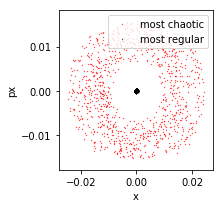

In [10]:
n = Nturn[-1]
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.imag(X[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.imag(X[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.A.png',dpi=180)

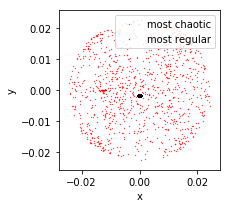

In [11]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.real(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.real(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.X.png',dpi=180)

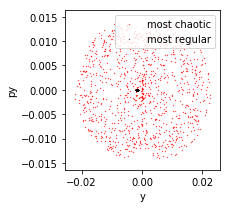

In [12]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(Y[n][:,iMax[n][0]]),np.imag(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(Y[n][:,iMin[n][0]]),np.imag(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.Y.png',dpi=180)

### Dynamic Aperture (Abs)

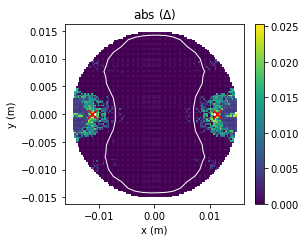

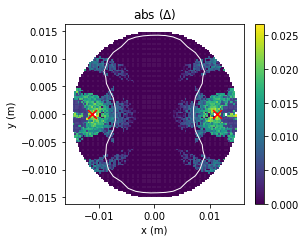

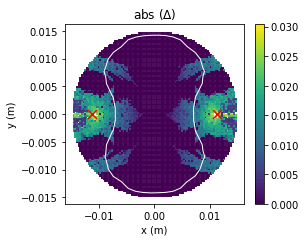

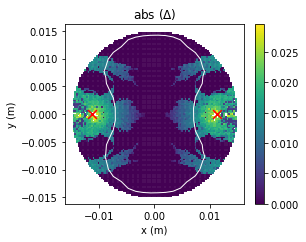

In [13]:
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'abs ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[250])
    plt.savefig('FB.DA.Abs.A.'+str(nturn)+'.png',dpi=180)    
    

### Dynamic Aperture (Sig)

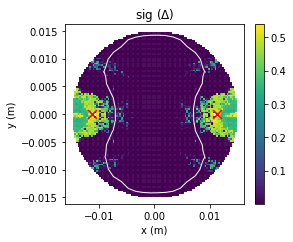

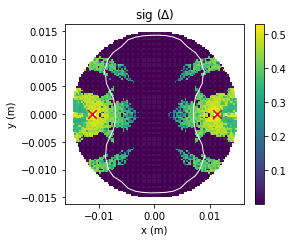

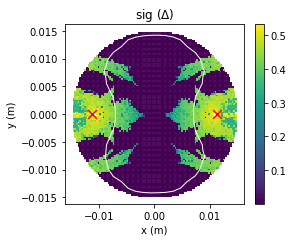

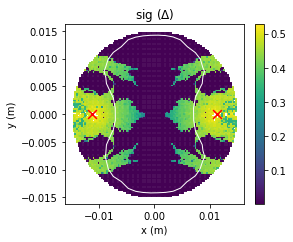

In [14]:
Adiff = AdiffSig
Xdiff = XdiffSig
Ydiff = YdiffSig

for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'sig ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[250])
    plt.savefig('FB.DA.Sig.A.'+str(nturn)+'.png',dpi=180)    

### Dynamic Aperture (log)

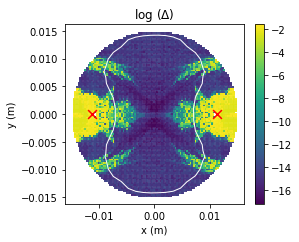

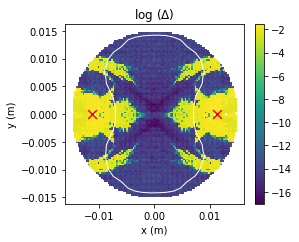

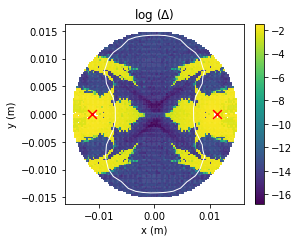

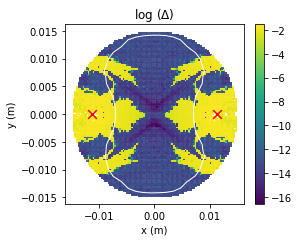

In [15]:
Adiff = AdiffLog
Xdiff = XdiffLog
Ydiff = YdiffLog

for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[250])
    plt.savefig('FB.DA.Log.A.'+str(nturn)+'.png',dpi=180)    

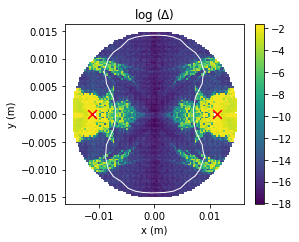

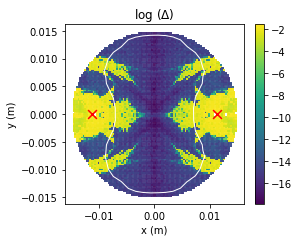

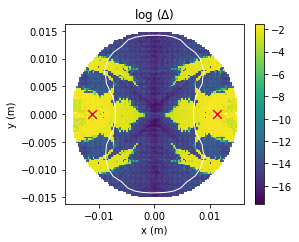

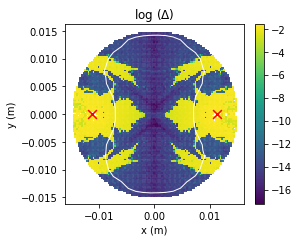

In [16]:
for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Xdiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][1]]),np.real(Y[n][0,iMax[n][1]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[250])
    plt.savefig('FB.DA.Log.X.'+str(nturn)+'.png',dpi=180)

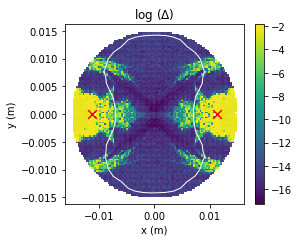

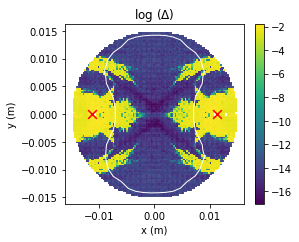

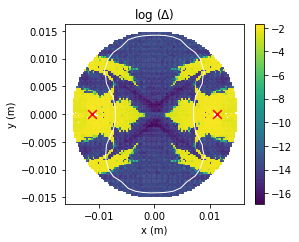

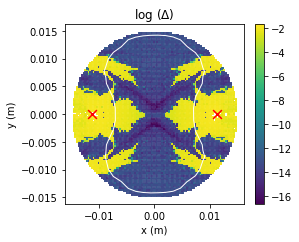

In [17]:
for n in Nturn:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Ydiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][2]]),np.real(Y[n][0,iMax[n][2]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.contour(counts.transpose(),
                extent=[np.min(pData[:,0]),np.max(pData[:,0]),np.min(pData[:,2]),np.max(pData[:,2])],
                linewidths=1,colors='white',linestyles='solid',levels=[250])
    plt.savefig('FB.DA.Log.Y.'+str(nturn)+'.png',dpi=180)